In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
#%matplotlib inline  # Configurations

/home/simon/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: FutureWarning: 'ms' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


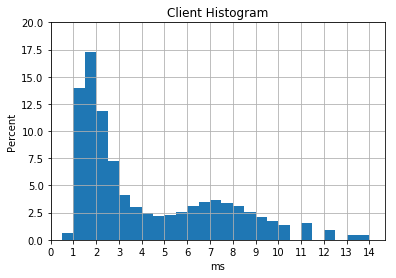

  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  contains: a callable function 
  figure: a :class:`matplotlib.figure.Figure` instance 
  gid: an id string 
  label: str 
  label1: str 
  label2: str 
  pad: float 
  path_effects: unknown
  picker: [None|float|boolean|callable] 
  rasterized: [True | False | None] 
  sketch_params: unknown
  snap: unknown
  transform: :class:`~matplotlib.transforms.Transform` instance 
  url: a url string 
  visible: [True | False] 
  zorder: any number 
  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.

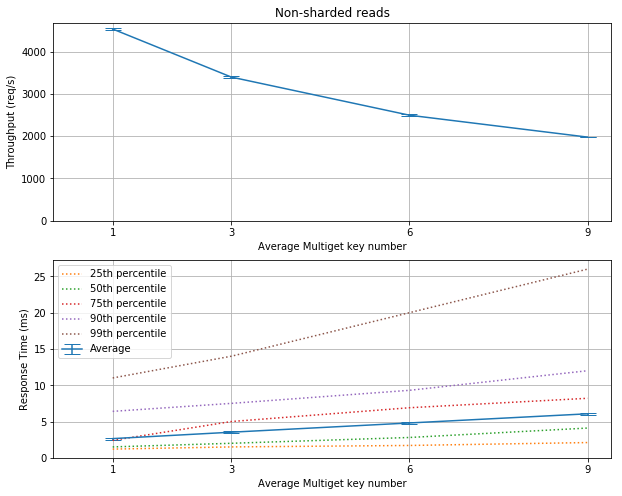

In [5]:
# Configurations
# 3 Servers
# 2 Middlewares
# 3 Client VMs
# 2 Memtier instances per VM
# CT=1
# 2 Middlewares
wt = 64
vc = 2
mkeys = [1, 3, 6, 9]
data_path = "/home/simon/eth/asl-fall17-project/experiment-scripts/5_gets_and_multigets/52_nonsharded_case/logs/wt64/"
figure_path = "/home/simon/eth/asl-fall17-project/report/Data/52/"
# mk = 1 3 6 9
total_throughput = []
total_throughput_std = []
get_throughput = []
get_throughput_std = []
set_throughput = []
set_throughput_std = []

total_response_time = []
total_response_time_std = []
get_response_time = []
get_response_time_std = []
set_response_time = []
set_response_time_std = []

total_histograms = []

max_throughputs = []

for mk in mkeys:
    mk_max_throughput = 0
    mk_total_throughput = []
    mk_get_throughput = []
    mk_set_throughput = []
    
    mk_total_rts = []
    mk_get_rts = []
    mk_set_rts = []
    for rep in xrange(1,4):
        rep_total_throughput = 0
        rep_get_throughput = 0
        rep_set_throughput = 0
        rep_total_hist = None

        for client in xrange(1,4):
            for inst in xrange(1,3):
                fullpath = data_path+"mk_"+str(mk)+"/GETS/"+"client"+str(client)+"_inst1_get_rep"+str(rep)+".json"
                data = json.load(open(fullpath))['ALL STATS']
                #print data
                fields = ['Sets','Gets','Totals']
                stats = []
                for f in fields:
                    if f in data:
                        data[f]["Type"] = f
                        stats.append(data[f])
                stats = pd.DataFrame(stats)
                #print(stats)
                rep_total_throughput += stats['Ops/sec'][2]
                rep_set_throughput += stats['Ops/sec'][0]
                #print(stats['Ops/sec'][2])
                rep_get_throughput += stats['Ops/sec'][1]
                mk_total_rts.append(stats['Latency'][2])
                mk_set_rts.append(stats['Latency'][0])
                mk_get_rts.append(stats['Latency'][1])
                
                # Histogram for single instance, client, rep
                sets = pd.DataFrame(data['SET'],dtype=float)
                sets.columns = ['ms','percent']
                sets['percent'] = sets['percent'].diff().fillna(0)
                
                gets = pd.DataFrame(data['GET'],dtype=float)
                gets.columns = ['ms','percent']
                gets['percent'] = gets['percent'].diff().fillna(0)
                
                hist = pd.concat([gets,sets]).groupby('ms').agg('sum')/2
                hist['ms'] = hist.index
                
                mk_max_throughput = np.maximum(mk_max_throughput, stats['Ops/sec'][2])

                if client == 1 and inst == 1 and rep == 1:
                    rep_total_hist = hist
                else:
                    rep_total_hist = pd.concat([rep_total_hist, hist]).groupby('ms').agg('sum')/2
                    rep_total_hist['ms'] = rep_total_hist.index
    
                
        mk_total_throughput.append(rep_total_throughput)
        mk_get_throughput.append(rep_get_throughput)
        mk_set_throughput.append(rep_set_throughput)
    total_histograms.append(rep_total_hist)
        
    total_throughput.append(np.mean(mk_total_throughput))
    total_throughput_std.append(np.std(mk_total_throughput))
    get_throughput.append(np.mean(mk_get_throughput))
    get_throughput_std.append(np.std(mk_get_throughput))
    set_throughput.append(np.mean(mk_set_throughput))
    set_throughput_std.append(np.std(mk_set_throughput))
    
    total_response_time.append(np.mean(mk_total_rts))
    total_response_time_std.append(np.std(mk_total_rts))
    get_response_time.append(np.mean(mk_get_rts))
    get_response_time_std.append(np.std(mk_get_rts))
    set_response_time.append(np.mean(mk_set_rts))
    set_response_time_std.append(np.std(mk_set_rts))
    
    max_throughputs.append(mk_max_throughput)

percentiles = [[],[],[],[],[]]
for histogram in total_histograms:
    histogram['cumsum'] = 100*histogram.percent.cumsum()/histogram.percent.cumsum().iloc[-1]
    p25 = histogram[histogram['cumsum'].gt(25)].index[0]
    p50 = histogram[histogram['cumsum'].gt(50)].index[0]
    p75 = histogram[histogram['cumsum'].gt(75)].index[0]
    p90 = histogram[histogram['cumsum'].gt(90)].index[0]
    p99 = histogram[histogram['cumsum'].gt(99)]
    if len(p99) == 0:
        p99 = histogram['cumsum'].iloc[-1]
    else:
        p99 = histogram[histogram['cumsum'].gt(99)].index[0]
    percentiles[0].append(p25)
    percentiles[1].append(p50)
    percentiles[2].append(p75)
    percentiles[3].append(p90)
    percentiles[4].append(p99)
    

figure2 = plt.figure(2, figsize=(6,4))
total_histograms[2]['percent'] = total_histograms[2]['percent']
total_histograms[2].index.names = ['ms']
total_histograms[2]['ms'].hist(bins=28, weights=total_histograms[2]['percent'], range=(0,14))
plt.title("Client Histogram")
plt.ylabel("Percent")
plt.xlabel("ms")
plt.xticks(xrange(0,15))
plt.ylim(0,20)
plt.xlim(0)
plt.show()
figure2.savefig(figure_path+"52_client_histogram.png")

# Write to file
import distutils.dir_util
p = figure_path + "51_client_histogram/"
distutils.dir_util.mkpath(p)
f = open(p+"processed.log", "w+")
f.write('time\r\n')
for i in total_histograms[2]['ms']:
    f.write(str(i) + " ")
f.write('percent\r\n')
for i in total_histograms[2]['percent']:
    f.write(str(i) + " ")
f.close()

    
# GRAPH
from itertools import cycle
X_axis = mkeys

lines = ["-","--","-.",":"]
linecycler = cycle(lines)

# Write to file
import distutils.dir_util
p = figure_path + "52_all_requests/"
distutils.dir_util.mkpath(p)
f = open(p+"processed.log", "w+")
f.write("X_axis\r\n")
f.write(str(X_axis))

figure1 = plt.figure(1, figsize=(10, 8))
figure1.add_subplot(2,1,1)
graph = plt.errorbar(X_axis, total_throughput, yerr=total_throughput_std, capsize=8)
plt.title("Non-sharded reads")
plt.setp([plt.xticks(X_axis)])
plt.legend()
plt.grid(True)
plt.xlabel("Average Multiget key number")
plt.ylabel("Throughput (req/s)")
plt.ylim(0)
plt.xlim(0)
f.write("\r\nmixed_mean_tp \r\n")
f.write(str(total_throughput))
f.write("\r\nmixed_stddev_tp \r\n")
f.write(str(total_throughput_std))

figure1.add_subplot(2,1,2)
f.write("\r\navg_rt\r\n")
f.write(str(total_response_time))
f.write("\r\nstd_rt\r\n")
f.write(str(total_response_time_std))
graph = plt.errorbar(X_axis, total_response_time, yerr=total_response_time_std, capsize=8, label="Average")
labels = ["25th", "50th", "75th", "90th", "99th"]
for i in xrange(5):
    plt.plot(X_axis, percentiles[i][:], label =labels[i] + " percentile", linestyle=':')
    f.write("\r\npercentile " + labels[i] + " rt\r\n")
    f.write(str(percentiles[i]))
plt.setp([plt.xticks(X_axis)])
plt.legend()
plt.grid(True)
plt.xlabel("Average Multiget key number")
plt.ylabel("Response Time (ms)")
plt.ylim(0)
plt.xlim(0)
figure1.savefig(figure_path+"52_all_requests.png")
f.close()

print "MW utilizations"
print np.divide(total_throughput, np.multiply(6,max_throughputs))


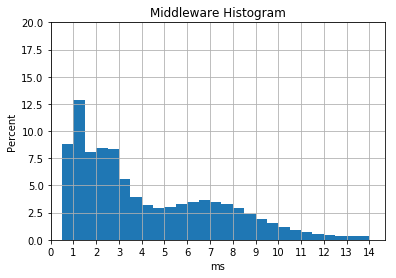

In [6]:
# Middleware Histogram
mwpath = data_path+"mk_"+str(6)+"/GETS/"
mw_hist = None
init = False
for directory, subdirectory, files in os.walk(mwpath):
            if(len(files) == 4):
                # We're in a MW folder
                rt_histogram = pd.read_csv(directory+"/ResponseTimeHistogram.csv")
                if(not init):
                    init = True
                    mw_hist = pd.DataFrame(rt_histogram)
                else:
                    new_hist = pd.DataFrame(rt_histogram)
                    mw_hist['requestcount'] = mw_hist['requestcount'] + new_hist['requestcount']
                       
                #resptime = resptime/total_count/1000.0
                
figure4 = plt.figure(4, figsize=(6,4))
mw_hist['requestcount'] = mw_hist['requestcount'].fillna(0)
mw_hist['time'] = mw_hist['time'] / 1000
mw_hist['percent'] = 100*mw_hist['requestcount']/(mw_hist['requestcount'].sum())
mw_hist['time'].hist(bins=28, weights=mw_hist['percent'],range=(0,14))

# plt.hist(total_histograms[2])
plt.title("Middleware Histogram")
plt.ylabel("Percent")
plt.xlabel("ms")
plt.ylim(0,20)
plt.xlim(0)
plt.xticks(xrange(0,15))
plt.show()
figure4.savefig(figure_path+"52_mw_histogram.png")

# Write to file
import distutils.dir_util
p = figure_path + "52_middleware_histogram/"
distutils.dir_util.mkpath(p)
f = open(p+"processed.log", "w+")
f.write('time\r\n')
for i in mw_hist['time']:
    f.write(str(i) + " ")
f.write('percent\r\n')
for i in mw_hist['percent']:
    f.write(str(i) + " ")
f.close()


In [7]:
# service times
servicetimes = []
for mk in mkeys:
    path = data_path+"mk_"+str(mk)+"/GETS/"
    servicetimesum = 0
    denom = 0
    # SETS
    for directory, subdirectory, files in os.walk(path):
        if(subdirectory == ['MW2', 'MW1']):
            # MW1
            for directory, subdirectory, files in os.walk(path+"MW1/"):
                if(len(files) == 4 ):
                    # We're in a MW folder
                    table = pd.read_csv(directory+"/MeasurementTable.csv",index_col=False)
                    total_count = 0

                    servicetimesum += np.sum(table['avgSetServiceTime'][2:])
                    denom += len(table['avgSetServiceTime'][2:])
            # MW2
            for directory, subdirectory, files in os.walk(path+"MW2/"):
                if(len(files) ==4 ):
                    # We're in a MW folder
                    table = pd.read_csv(directory+"/MeasurementTable.csv",index_col=False)
                    total_count = 0

                    servicetimesum += np.sum(table['avgSetServiceTime'][2:])
                    denom += len(table['avgSetServiceTime'][2:])
    servicetimes.append(np.divide(servicetimesum, denom))
print servicetimes
print "Server Utilizations"
print np.divide(np.multiply(servicetimes, total_throughput), 1000000)

[222, 285, 382, 477]
Server Utilizations
[ 1.00674484  0.9680671   0.9528608   0.94259334]
